### Задача 7.

ПРОГНОЗ ОТТОКА ПОЛЬЗОВАТЕЛЕЙ КРЕДИТНЫХ КАРТ. Необходимо построить прогнозную модель, которая сможет определить, перестанет ли клиент банка пользоваться кредитной картой.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, auc,
                             classification_report)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import StackingClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, RandomOverSampler
from pathlib import Path  
from sklearn.feature_selection import SelectFromModel

In [2]:
df = pd.read_csv('Data/credit.csv')
df.head(7)

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,715630983,31,F,0,Graduate,Single,Less than $40K,Blue,21,4,...,3,4598.0,0,4598.0,0.439,6317,77,0.833,0.000,Attrited Customer
1,713643858,53,F,1,College,Married,$40K - $60K,Blue,43,4,...,2,1525.0,1411,114.0,0.660,1911,47,0.958,0.925,Existing Customer
2,708334158,46,F,3,Graduate,Divorced,Less than $40K,Blue,34,4,...,4,9863.0,686,9177.0,0.581,3068,58,0.933,0.070,Existing Customer
3,711033408,50,F,2,High School,Married,Less than $40K,Blue,36,5,...,2,9355.0,1626,7729.0,0.701,1230,28,0.867,0.174,Existing Customer
4,711368283,39,M,2,Unknown,Married,$80K - $120K,Blue,27,3,...,2,34516.0,1629,32887.0,1.078,3448,53,1.038,0.047,Existing Customer
5,779458383,50,F,3,High School,Married,Less than $40K,Blue,32,6,...,3,2590.0,2087,503.0,0.700,4248,73,0.780,0.806,Existing Customer
6,780272208,39,F,1,Graduate,Unknown,Less than $40K,Blue,25,4,...,3,2006.0,1197,809.0,0.877,4139,69,0.769,0.597,Existing Customer


### Предобработка данных

В качестве целевого столбца выберем 'Attrition_Flag' и заменим значения на 1 и 0. Сам столбец удалим из массива данных

In [3]:
df.loc[df['Attrition_Flag'] == 'Attrited Customer', 'Attrition_Flag'] = 1
df.loc[df['Attrition_Flag'] == 'Existing Customer', 'Attrition_Flag'] = 0
y = df['Attrition_Flag']
df = df.drop(['Attrition_Flag'], axis = 1)

In [4]:
y = pd.DataFrame(y)
y = y.astype(int)

Обработаем категориальные и числовые признаки. Категорийные переведем в формат 0 и 1, удалив столбец с первым значением. Числовые - прошкалируем. Затем соединим оба массива данных в единый.

In [5]:
categorical_features = [x for x in df.columns if df[x].dtype == 'O']
categorical_features

['Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

In [6]:
x_cat = pd.get_dummies(df[categorical_features], drop_first = True)

In [7]:
numerical_features = [x for x in df.columns if df[x].dtype != 'O']
numerical_features

['CLIENTNUM',
 'Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [8]:
x_num = df[numerical_features]
x_num = x_num.drop(['CLIENTNUM'], axis = 1)

scaler = StandardScaler()
x_num = scaler.fit_transform(x_num)
x_num = pd.DataFrame(x_num, columns = numerical_features[1:])

In [9]:
x = pd.concat([x_num, x_cat], axis = 1)
x

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,-1.924759,-1.812342,-1.890052,0.119993,-0.351190,0.489887,-0.445698,-1.431939,-0.317708,-1.449561,...,1,0,0,0,0,1,0,0,0,0
1,0.842332,-1.042201,0.895128,0.119993,1.629715,-0.414511,-0.783332,0.302140,-0.810413,-0.450176,...,0,0,1,0,0,0,0,0,0,0
2,-0.038106,0.498082,-0.244264,0.119993,-0.351190,1.394286,0.132775,-0.588864,0.185436,-0.807422,...,0,0,0,0,0,1,0,0,0,0
3,0.465002,-0.272059,0.008934,0.766337,-1.341643,-0.414511,0.076960,0.566368,0.026329,-0.264769,...,0,0,0,0,0,1,0,0,0,0
4,-0.918544,-0.272059,-1.130457,-0.526352,0.639263,-0.414511,2.841433,0.570055,2.790709,1.440065,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7590,-1.924759,-1.042201,-1.890052,-0.526352,-0.351190,-0.414511,0.725861,-0.069010,0.732093,-0.472786,...,0,1,0,0,0,1,0,1,0,0
7591,-0.038106,2.038366,0.768529,-1.819041,-1.341643,0.489887,2.666738,0.460677,2.625778,0.463290,...,0,0,0,0,0,0,0,0,0,0
7592,-0.792767,-0.272059,-1.383655,1.412682,1.629715,-0.414511,-0.623689,-1.431939,-0.495715,-1.218934,...,0,0,0,1,0,0,0,0,0,0
7593,-0.038106,-0.272059,0.008934,0.119993,-0.351190,-0.414511,-0.737845,-0.590093,-0.685149,-1.530959,...,0,0,0,1,0,0,0,0,0,0


Разобъем данные на тестовую и учебную выборки. Протестируем на данных все классификаторы для определения наиболее эффективных.

<AxesSubplot: xlabel='Attrition_Flag'>

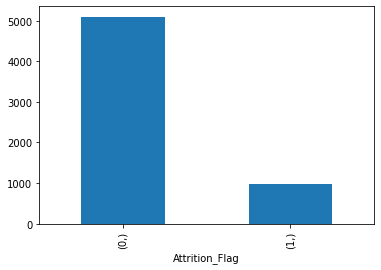

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)
y_train.value_counts().plot(kind = 'bar')

In [11]:
names = ['LogisticRegression', 'Linear_SVM', 'Polynomial_SVM', 'RBF_SVM', 'Gradient_Boosting',
         'Decision_Tree','Extra_Trees', 'Random_Forest', 'Neural_Net', 'AdaBoost', 'Naive_Bayes','QDA','SGD',
         'Nearest_Neighbors', 'XGB'
        ]

classifiers = [LogisticRegression(), 
               SVC(kernel="linear", C=0.025),
               SVC(kernel="poly", degree=3, C=0.025),
               SVC(kernel="rbf", C=1, gamma=2),
               GradientBoostingClassifier(n_estimators=400, learning_rate=0.05),
               DecisionTreeClassifier(max_depth=5),
               ExtraTreesClassifier(n_estimators=10, min_samples_split=2),
               RandomForestClassifier(max_depth=8, n_estimators=100),
               MLPClassifier(alpha=1, max_iter=1000),
               AdaBoostClassifier(n_estimators=400, learning_rate=0.05),
               GaussianNB(),
               QuadraticDiscriminantAnalysis(),
               SGDClassifier(loss="hinge", penalty="l2"),
               KNeighborsClassifier(3), 
               XGBClassifier(n_estimators=600, learning_rate=0.05)
              ]

In [12]:
scores = pd.DataFrame()
for name, clf in zip(names, classifiers):
    
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    new_row = {'Test':name, 'Accuracy':round(accuracy_score(y_test, y_pred),4),
               'Precision':round(precision_score(y_test, y_pred),4),
               'Recall': round(recall_score(y_test, y_pred),4),
               'F1 score': round(f1_score(y_test, y_pred),4)
              }
    scores = scores.append(new_row, ignore_index=True)

scores = scores.set_index('Test')

display(scores.sort_values(by = ['Accuracy'], ascending=False))

,Accuracy,F1 score,Precision,Recall
Test,,,,
XGB,0.9710,0.9087,0.9280,0.8902
Gradient_Boosting,0.9645,0.8861,0.9211,0.8537
Random_Forest,0.9348,0.7648,0.9200,0.6545
AdaBoost,0.9322,0.7494,0.9333,0.6260
Neural_Net,0.9309,0.7586,0.8730,0.6707
Decision_Tree,0.9289,0.7702,0.8080,0.7358
Extra_Trees,0.9078,0.6316,0.8955,0.4878
LogisticRegression,0.9045,0.6636,0.7730,0.5813
Linear_SVM,0.9045,0.6437,0.8137,0.5325


Посмотрим на значимость всех параметров в модели. Для этого воспользуемся готовыми интсрументами.

<AxesSubplot: >

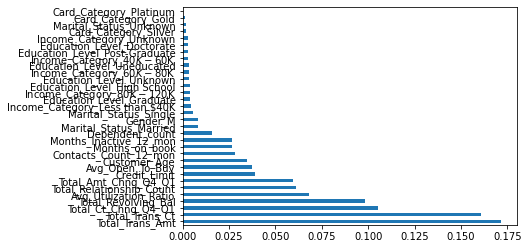

In [13]:
fs_rf=SelectFromModel(RandomForestClassifier()).fit(x_train,y_train)
imp_rf=pd.Series(fs_rf.estimator_.feature_importances_,index=x_train.columns).sort_values(ascending=False)
imp_rf.plot(kind='barh')

<AxesSubplot: >

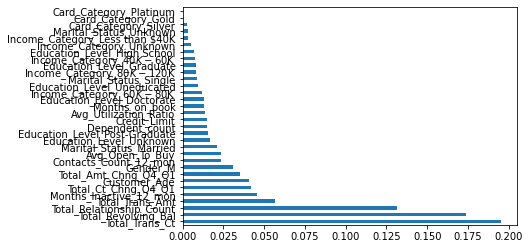

In [14]:
fs_xgb=SelectFromModel(XGBClassifier()).fit(x_train,y_train)
imp_xgb=pd.Series(fs_xgb.estimator_.feature_importances_,index=x_train.columns).sort_values(ascending=False)
imp_xgb.plot(kind='barh')

### Вывод (промежуточный)

Интересный вывоод - категориальные признаки имеют очень низкое влияние на итоговую метрику. Попробуем посмотреть, как модель будет вести себя без них.

Лучше всего на данных работают бустингы и деревья с лесами. Попробуем из них составить стекинговую модель. Протестируем модель продолжая работать с исходными данными. 

Проведем эксперимент и сравним результаты работы стекинговой модели, изменяя параметры исходных данных:

    * 1. используем весь набор данных, оставляем несбалансированность учебной выборки
    * 2. используем только количественные признаки, оставлем несбаланисрованность учебной выборки
    * 3. используем весь набор данных, БАЛАНСИРУЕМ учебную выборку с помощью SMOTE
    * 4. используем только количественные признкаи, БАЛАНСИРУЕМ учебную выборку с помощью SMOTE
    
    
   
 ### Тест 1: используем весь набор данных, оставляем несбалансированность учебной выборки (sclf_1)

In [15]:
xgb_boost = XGBClassifier(learning_rate = 0.05, n_estimators = 600, random_state = 42)
grd_boost = GradientBoostingClassifier(n_estimators=400, learning_rate=0.05, random_state = 42)
ada_boost = AdaBoostClassifier(n_estimators=400, learning_rate=0.05, random_state = 42)
e_trees = ExtraTreesClassifier(n_estimators=400, min_samples_split=2, random_state = 42)
r_forest = RandomForestClassifier(n_estimators=600, random_state = 42)

lgclassifier = LogisticRegression(random_state = 42)

estimators = [('xgb', xgb_boost), 
              ('grb',grd_boost ),
              ('adb', ada_boost),
              ('rfc', r_forest),
              ('etc', e_trees)
             ]
sclf_1 = StackingClassifier(estimators=estimators,
                            final_estimator=lgclassifier,
                            cv=10)

In [16]:
xgb_boost.fit(x_train, y_train)
print(f"XGBoost model training Accuracy: {xgb_boost.score(x_train, y_train):0.4f}")
print(f"XGBoost model test Accuracy: {xgb_boost.score(x_test, y_test):0.4f}")

grd_boost.fit(x_train, y_train)
print(f"\nGrad boost model training Accuracy: {grd_boost.score(x_train, y_train):0.4f}")
print(f"Grad boost model test Accuracy: {grd_boost.score(x_test, y_test):0.4f}")

ada_boost.fit(x_train, y_train)
print(f"\nADABoost model training Accuracy: {ada_boost.score(x_train, y_train):0.4f}")
print(f"ADABoost model test Accuracy: {ada_boost.score(x_test, y_test):0.4f}")

r_forest.fit(x_train, y_train)
print(f"\nRandom forest model training Accuracy: {r_forest.score(x_train, y_train):0.4f}")
print(f"Random forest model test Accuracy: {r_forest.score(x_test, y_test):0.4f}")

e_trees.fit(x_train, y_train)
print(f"\nEtrees model training Accuracy: {e_trees.score(x_train, y_train):0.4f}")
print(f"Etrees model test Accuracy: {e_trees.score(x_test, y_test):0.4f}")

sclf_1.fit(x_train, y_train)
print(f"\nStacking classifier training Accuracy: {sclf_1.score(x_train, y_train):0.4f}")
print(f"Stacking classifier test Accuracy: {sclf_1.score(x_test, y_test):0.4f}")

XGBoost model training Accuracy: 1.0000
XGBoost model test Accuracy: 0.9710

Grad boost model training Accuracy: 0.9883
Grad boost model test Accuracy: 0.9645

ADABoost model training Accuracy: 0.9422
ADABoost model test Accuracy: 0.9322

Random forest model training Accuracy: 1.0000
Random forest model test Accuracy: 0.9500

Etrees model training Accuracy: 1.0000
Etrees model test Accuracy: 0.9289

Stacking classifier training Accuracy: 0.9995
Stacking classifier test Accuracy: 0.9691


In [17]:
stacks_compare = pd.DataFrame()
sclf_pred = sclf_1.predict(x_test)

new_row = {'Test':'Sclf 1 full data', 'Accuracy':round(accuracy_score(y_test, sclf_pred),4),
               'Precision':round(precision_score(y_test, sclf_pred),4),
               'Recall': round(recall_score(y_test, sclf_pred),4),
               'F1 score': round(f1_score(y_test, sclf_pred),4)
              }
stacks_compare = stacks_compare.append(new_row, ignore_index=True)


display(stacks_compare.sort_values(by = ['F1 score'], ascending=False))

,Accuracy,F1 score,Precision,Recall,Test
0,0.9691,0.9015,0.9307,0.874,Sclf 1 full data


In [18]:
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(sclf_1, x_test, y_test, cv=4)

display(cv_score)
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_score.mean(), cv_score.std() * 2))

array([0.95      , 0.94736842, 0.94736842, 0.95514512])

Accuracy: 0.95 (+/- 0.01)


### Тест 2: используем только количественные признаки, оставлем несбаланисрованность учебной выборки (sclf_2)

In [28]:
x_train_1 = x_train[numerical_features[1:]]
x_test_1 = x_test[numerical_features[1:]]

In [29]:
xgb_boost_1 = XGBClassifier(learning_rate = 0.05, n_estimators = 600, random_state = 42)
grd_boost_1 = GradientBoostingClassifier(n_estimators=400, learning_rate=0.05, random_state = 42)
ada_boost_1 = AdaBoostClassifier(n_estimators=400, learning_rate=0.05, random_state = 42)
e_trees_1 = ExtraTreesClassifier(n_estimators=400, min_samples_split=2, random_state = 42)
r_forest_1 = RandomForestClassifier(n_estimators=600, random_state = 42)

lgclassifier_1 = LogisticRegression(random_state = 42)

estimators = [('xgb', xgb_boost_1), 
              ('grb',grd_boost_1 ),
              ('adb', ada_boost_1),
              ('rfc', r_forest_1),
              ('etc', e_trees_1)
             ]
sclf_2 = StackingClassifier(estimators=estimators,
                            final_estimator=lgclassifier_1,
                            cv=10)

In [30]:
xgb_boost_1.fit(x_train_1, y_train)
print(f"XGBoost model training Accuracy: {xgb_boost_1.score(x_train_1, y_train):0.4f}")
print(f"XGBoost model test Accuracy: {xgb_boost_1.score(x_test_1, y_test):0.4f}")

grd_boost_1.fit(x_train_1, y_train)
print(f"\nGrad boost model training Accuracy: {grd_boost_1.score(x_train_1, y_train):0.4f}")
print(f"Grad boost model test Accuracy: {grd_boost_1.score(x_test_1, y_test):0.4f}")

ada_boost_1.fit(x_train_1, y_train)
print(f"\nADABoost model training Accuracy: {ada_boost_1.score(x_train_1, y_train):0.4f}")
print(f"ADABoost model test Accuracy: {ada_boost_1.score(x_test_1, y_test):0.4f}")

r_forest_1.fit(x_train_1, y_train)
print(f"\nRandom forest model training Accuracy: {r_forest_1.score(x_train_1, y_train):0.4f}")
print(f"Random forest model test Accuracy: {r_forest_1.score(x_test_1, y_test):0.4f}")

e_trees_1.fit(x_train_1, y_train)
print(f"\nEtrees model training Accuracy: {e_trees_1.score(x_train_1, y_train):0.4f}")
print(f"Etrees model test Accuracy: {e_trees_1.score(x_test_1, y_test):0.4f}")

sclf_2.fit(x_train_1, y_train)
print(f"\nStacking classifier training Accuracy: {sclf_2.score(x_train_1, y_train):0.4f}")
print(f"Stacking classifier test Accuracy: {sclf_2.score(x_test_1, y_test):0.4f}")

XGBoost model training Accuracy: 1.0000
XGBoost model test Accuracy: 0.9677

Grad boost model training Accuracy: 0.9875
Grad boost model test Accuracy: 0.9651

ADABoost model training Accuracy: 0.9422
ADABoost model test Accuracy: 0.9322

Random forest model training Accuracy: 1.0000
Random forest model test Accuracy: 0.9546

Etrees model training Accuracy: 1.0000
Etrees model test Accuracy: 0.9408

Stacking classifier training Accuracy: 1.0000
Stacking classifier test Accuracy: 0.9658


In [31]:
sclf_pred = sclf_2.predict(x_test_1)

new_row = {'Test':'Sclf 2 only num', 'Accuracy':round(accuracy_score(y_test, sclf_pred),4),
               'Precision':round(precision_score(y_test, sclf_pred),4),
               'Recall': round(recall_score(y_test, sclf_pred),4),
               'F1 score': round(f1_score(y_test, sclf_pred),4)
              }
stacks_compare = stacks_compare.append(new_row, ignore_index=True)


display(stacks_compare.sort_values(by = ['F1 score'], ascending=False))

,Accuracy,F1 score,Precision,Recall,Test
0,0.9691,0.9015,0.9307,0.874,Sclf 1 full data
1,0.9658,0.8921,0.9110,0.874,Sclf 2 only num


In [32]:
cv_score = cross_val_score(sclf_2, x_test_1, y_test, cv=4)

display(cv_score)
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_score.mean(), cv_score.std() * 2))

array([0.95      , 0.95      , 0.95      , 0.95778364])

Accuracy: 0.95 (+/- 0.01)


### Тест 3: используем весь набор данных, БАЛАНСИРУЕМ учебную выборку с помощью SMOTE (sclf_3)

<AxesSubplot: xlabel='Attrition_Flag'>

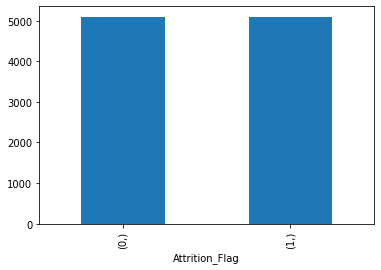

In [37]:
sm =  SMOTE(k_neighbors=5, random_state = 42)
x_train, y_train = sm.fit_resample(x_train, y_train)
y_train.value_counts().plot(kind = 'bar')

In [38]:
xgb_boost_2 = XGBClassifier(learning_rate = 0.05, n_estimators = 600, random_state = 42)
grd_boost_2 = GradientBoostingClassifier(n_estimators=400, learning_rate=0.05, random_state = 42)
ada_boost_2 = AdaBoostClassifier(n_estimators=400, learning_rate=0.05, random_state = 42)
e_trees_2 = ExtraTreesClassifier(n_estimators=400, min_samples_split=2, random_state = 42)
r_forest_2 = RandomForestClassifier(n_estimators=600, random_state = 42)

lgclassifier_2 = LogisticRegression(random_state = 42)

estimators = [('xgb', xgb_boost_2), 
              ('grb',grd_boost_2 ),
              ('adb', ada_boost_2),
              ('rfc', r_forest_2),
              ('etc', e_trees_2)
             ]
sclf_3 = StackingClassifier(estimators=estimators,
                            final_estimator=lgclassifier_2,
                            cv=10)

In [39]:
xgb_boost_2.fit(x_train, y_train)
print(f"XGBoost model training Accuracy: {xgb_boost_2.score(x_train, y_train):0.4f}")
print(f"XGBoost model test Accuracy: {xgb_boost_2.score(x_test, y_test):0.4f}")

grd_boost_2.fit(x_train, y_train)
print(f"\nGrad boost model training Accuracy: {grd_boost_2.score(x_train, y_train):0.4f}")
print(f"Grad boost model test Accuracy: {grd_boost_2.score(x_test, y_test):0.4f}")

ada_boost_2.fit(x_train, y_train)
print(f"\nADABoost model training Accuracy: {ada_boost_2.score(x_train, y_train):0.4f}")
print(f"ADABoost model test Accuracy: {ada_boost_2.score(x_test, y_test):0.4f}")

r_forest_2.fit(x_train, y_train)
print(f"\nRandom forest model training Accuracy: {r_forest_2.score(x_train, y_train):0.4f}")
print(f"Random forest model test Accuracy: {r_forest_2.score(x_test, y_test):0.4f}")

e_trees_2.fit(x_train, y_train)
print(f"\nEtrees model training Accuracy: {e_trees_2.score(x_train, y_train):0.4f}")
print(f"Etrees model test Accuracy: {e_trees_2.score(x_test, y_test):0.4f}")

sclf_3.fit(x_train, y_train)
print(f"\nStacking classifier training Accuracy: {sclf_3.score(x_train, y_train):0.4f}")
print(f"Stacking classifier test Accuracy: {sclf_3.score(x_test, y_test):0.4f}")

XGBoost model training Accuracy: 1.0000
XGBoost model test Accuracy: 0.9651

Grad boost model training Accuracy: 0.9876
Grad boost model test Accuracy: 0.9592

ADABoost model training Accuracy: 0.9407
ADABoost model test Accuracy: 0.9263

Random forest model training Accuracy: 1.0000
Random forest model test Accuracy: 0.9579

Etrees model training Accuracy: 1.0000
Etrees model test Accuracy: 0.9210

Stacking classifier training Accuracy: 1.0000
Stacking classifier test Accuracy: 0.9651


In [40]:
sclf_pred = sclf_3.predict(x_test)

new_row = {'Test':'Sclf 3 full data SMOTE', 'Accuracy':round(accuracy_score(y_test, sclf_pred),4),
               'Precision':round(precision_score(y_test, sclf_pred),4),
               'Recall': round(recall_score(y_test, sclf_pred),4),
               'F1 score': round(f1_score(y_test, sclf_pred),4)
              }
stacks_compare = stacks_compare.append(new_row, ignore_index=True)


display(stacks_compare.sort_values(by = ['F1 score'], ascending=False))

,Accuracy,F1 score,Precision,Recall,Test
0,0.9691,0.9015,0.9307,0.8740,Sclf 1 full data
1,0.9658,0.8921,0.9110,0.8740,Sclf 2 only num
2,0.9651,0.8921,0.8939,0.8902,Sclf 3 full data SMOTE


In [41]:
cv_score = cross_val_score(sclf_3, x_test, y_test, cv=4)

display(cv_score)
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_score.mean(), cv_score.std() * 2))

array([0.95      , 0.94736842, 0.94736842, 0.95514512])

Accuracy: 0.95 (+/- 0.01)


### Тест 4: используем только количественные признкаи, БАЛАНСИРУЕМ учебную выборку с помощью SMOTE (sclf_4)

In [46]:
x_train = x_train[numerical_features[1:]]
x_test = x_test[numerical_features[1:]]

In [47]:
xgb_boost_3 = XGBClassifier(learning_rate = 0.05, n_estimators = 600, random_state = 42)
grd_boost_3 = GradientBoostingClassifier(n_estimators=400, learning_rate=0.05, random_state = 42)
ada_boost_3 = AdaBoostClassifier(n_estimators=400, learning_rate=0.05, random_state = 42)
e_trees_3 = ExtraTreesClassifier(n_estimators=400, min_samples_split=2, random_state = 42)
r_forest_3 = RandomForestClassifier(n_estimators=600, random_state = 42)

lgclassifier_3 = LogisticRegression(random_state = 42)

estimators = [('xgb', xgb_boost_3), 
              ('grb',grd_boost_3 ),
              ('adb', ada_boost_3),
              ('rfc', r_forest_3),
              ('etc', e_trees_3)
             ]
sclf_4 = StackingClassifier(estimators=estimators,
                            final_estimator=lgclassifier_3,
                            cv=10)

In [48]:
xgb_boost_3.fit(x_train, y_train)
print(f"XGBoost model training Accuracy: {xgb_boost_3.score(x_train, y_train):0.4f}")
print(f"XGBoost model test Accuracy: {xgb_boost_3.score(x_test, y_test):0.4f}")

grd_boost_3.fit(x_train, y_train)
print(f"\nGrad boost model training Accuracy: {grd_boost_3.score(x_train, y_train):0.4f}")
print(f"Grad boost model test Accuracy: {grd_boost_3.score(x_test, y_test):0.4f}")

ada_boost_3.fit(x_train, y_train)
print(f"\nADABoost model training Accuracy: {ada_boost_3.score(x_train, y_train):0.4f}")
print(f"ADABoost model test Accuracy: {ada_boost_3.score(x_test, y_test):0.4f}")

r_forest_3.fit(x_train, y_train)
print(f"\nRandom forest model training Accuracy: {r_forest_3.score(x_train, y_train):0.4f}")
print(f"Random forest model test Accuracy: {r_forest_3.score(x_test, y_test):0.4f}")

e_trees_3.fit(x_train, y_train)
print(f"\nEtrees model training Accuracy: {e_trees_3.score(x_train, y_train):0.4f}")
print(f"Etrees model test Accuracy: {e_trees_3.score(x_test, y_test):0.4f}")

sclf_4.fit(x_train, y_train)
print(f"\nStacking classifier training Accuracy: {sclf_4.score(x_train, y_train):0.4f}")
print(f"Stacking classifier test Accuracy: {sclf_4.score(x_test, y_test):0.4f}")

XGBoost model training Accuracy: 1.0000
XGBoost model test Accuracy: 0.9658

Grad boost model training Accuracy: 0.9880
Grad boost model test Accuracy: 0.9592

ADABoost model training Accuracy: 0.9415
ADABoost model test Accuracy: 0.9197

Random forest model training Accuracy: 1.0000
Random forest model test Accuracy: 0.9559

Etrees model training Accuracy: 1.0000
Etrees model test Accuracy: 0.9526

Stacking classifier training Accuracy: 1.0000
Stacking classifier test Accuracy: 0.9638


In [49]:
sclf_pred = sclf_4.predict(x_test)

new_row = {'Test':'Sclf 4 only num SMOTE', 'Accuracy':round(accuracy_score(y_test, sclf_pred),4),
               'Precision':round(precision_score(y_test, sclf_pred),4),
               'Recall': round(recall_score(y_test, sclf_pred),4),
               'F1 score': round(f1_score(y_test, sclf_pred),4)
              }
stacks_compare = stacks_compare.append(new_row, ignore_index=True)


display(stacks_compare.sort_values(by = ['F1 score'], ascending=False))

,Accuracy,F1 score,Precision,Recall,Test
0,0.9691,0.9015,0.9307,0.8740,Sclf 1 full data
1,0.9658,0.8921,0.9110,0.8740,Sclf 2 only num
2,0.9651,0.8921,0.8939,0.8902,Sclf 3 full data SMOTE
3,0.9638,0.8857,0.9064,0.8659,Sclf 4 only num SMOTE


In [50]:
cv_score = cross_val_score(sclf_4, x_test, y_test, cv=4)

display(cv_score)
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_score.mean(), cv_score.std() * 2))

array([0.95      , 0.95      , 0.95      , 0.95778364])

Accuracy: 0.95 (+/- 0.01)


### Выводы (финальные):

Стекинг показал себя лучше всего в 1-м тесте на полных данных. Используем эту модель для предсказания по валидационной выборке

In [65]:
val = pd.read_csv('Data/validation.csv')
val_num = val[numerical_features]
val_num = val_num.drop(['CLIENTNUM'], axis = 1)
val_num = scaler.fit_transform(val_num)
val_num = pd.DataFrame(val_num, columns = numerical_features[1:])
val_num

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0.804481,-0.250077,0.858398,-0.512346,1.678405,1.402888,-0.262616,1.662697,-0.412595,-0.225598,-0.714049,-0.944898,1.469620,0.459678
1,-1.509676,-0.250077,-1.446957,1.391657,0.690557,0.499962,-0.604452,1.043399,-0.698079,-0.436601,-0.150895,0.515608,-0.000893,1.324295
2,0.195492,1.288670,0.251726,-0.512346,-0.297291,-0.402965,2.662828,0.398451,2.623851,0.843485,-0.706359,-1.202634,-0.738331,-0.833676
3,0.195492,1.288670,-0.354946,-1.147014,-0.297291,0.499962,2.868173,1.105696,2.765048,-0.183397,-0.905415,-1.417414,-1.117958,-0.780084
4,0.195492,0.519297,0.130391,-0.512346,-0.297291,1.402888,-0.223603,-0.044951,-0.219291,-1.243102,-0.150599,-0.085776,-1.218320,-0.383503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2527,-1.631474,1.288670,-1.689626,0.756989,-1.285139,-0.402965,-0.725360,0.074755,-0.731309,0.065118,-0.369472,1.460642,-0.018347,1.177810
2528,-0.900687,-0.250077,-2.053629,-0.512346,0.690557,-0.402965,-0.609757,1.214409,-0.718834,0.566836,-0.830880,-1.202634,2.621594,1.527945
2529,-0.657092,0.519297,-0.961619,0.122321,-1.285139,0.499962,0.870759,0.253093,0.846915,-0.342822,-0.047078,-0.042820,-0.118708,-0.697909
2530,-0.657092,2.058044,-0.961619,-1.147014,0.690557,0.499962,-0.780288,-0.226954,-0.758908,0.482435,-0.476246,-0.601249,2.207057,1.310004


In [66]:
val_cat = pd.get_dummies(val[categorical_features], drop_first = True)
val_cat

,Gender_M,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
4,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2527,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2528,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0
2529,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
2530,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [67]:
val_fin = pd.concat([val_num, val_cat], axis = 1)
val_fin

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0.804481,-0.250077,0.858398,-0.512346,1.678405,1.402888,-0.262616,1.662697,-0.412595,-0.225598,...,1,0,1,0,0,0,0,0,0,0
1,-1.509676,-0.250077,-1.446957,1.391657,0.690557,0.499962,-0.604452,1.043399,-0.698079,-0.436601,...,1,0,0,0,0,0,1,0,0,0
2,0.195492,1.288670,0.251726,-0.512346,-0.297291,-0.402965,2.662828,0.398451,2.623851,0.843485,...,0,1,0,1,0,0,0,0,0,1
3,0.195492,1.288670,-0.354946,-1.147014,-0.297291,0.499962,2.868173,1.105696,2.765048,-0.183397,...,0,0,0,1,0,0,0,1,0,0
4,0.195492,0.519297,0.130391,-0.512346,-0.297291,1.402888,-0.223603,-0.044951,-0.219291,-1.243102,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2527,-1.631474,1.288670,-1.689626,0.756989,-1.285139,-0.402965,-0.725360,0.074755,-0.731309,0.065118,...,1,0,0,0,0,1,0,0,0,0
2528,-0.900687,-0.250077,-2.053629,-0.512346,0.690557,-0.402965,-0.609757,1.214409,-0.718834,0.566836,...,0,0,0,1,0,0,0,0,0,0
2529,-0.657092,0.519297,-0.961619,0.122321,-1.285139,0.499962,0.870759,0.253093,0.846915,-0.342822,...,1,0,0,1,0,0,0,0,0,0
2530,-0.657092,2.058044,-0.961619,-1.147014,0.690557,0.499962,-0.780288,-0.226954,-0.758908,0.482435,...,0,0,0,0,0,1,0,0,0,0


In [68]:
submission = pd.DataFrame()

sclf_pred = sclf_1.predict(val_fin)
submission['churn'] = sclf_pred
submission

,churn
0,0
1,0
2,0
3,1
4,0
...,...
2527,0
2528,0
2529,0
2530,1


In [69]:
submission = pd.concat([val['CLIENTNUM'], submission], axis = 1)
submission

,CLIENTNUM,churn
0,719682183,0
1,711341433,0
2,716154258,0
3,779749908,1
4,710854008,0
...,...,...
2527,710268858,0
2528,714130233,0
2529,708823908,0
2530,771045708,1


In [73]:
submission = submission.rename(columns = {'CLIENTNUM': 'client_id', 'sclf2':'churn'})
submission = submission.set_index('client_id')
submission

,churn
client_id,
719682183,0
711341433,0
716154258,0
779749908,1
710854008,0
...,...
710268858,0
714130233,0
708823908,0


In [74]:
from pathlib import Path  
filepath = Path('Data/7_result_shakhova.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)  
submission.to_csv(filepath)